In [1]:
import tensorflow as tf

import os
import tensorflow_datasets as tfds

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [3]:
strategy = tf.distribute.TPUStrategy(resolver)

In [4]:
!pip install hickle
import hickle as hkl
import os
import matplotlib.pyplot as plt
from keras import layers,Input,Sequential
from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D,MaxPooling2D,Reshape,Resizing,Dropout,UpSampling2D,BatchNormalization
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from google.colab  import drive
drive.mount("/gdrive")
%cd /gdrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.2 MB/s eta 0:00:00
Mounted at /gdrive
/gdrive


In [5]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_v1/Static/Left45.hkl")
X_train=load_hkl['xtrain'] / 255.
X_test=load_hkl['xtest'] / 255.
y_train=load_hkl['ytrain']
y_test=load_hkl['ytest']

In [6]:
X_train.shape

(205, 480, 640, 3)

In [7]:
class CNN_Autoencoder(Model):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=X_train.shape[1:]),
            layers.Conv2D(8, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='relu')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
epochs=40

In [9]:
with strategy.scope():
  cnn_autoencoder_front=CNN_Autoencoder()
  cnn_autoencoder_front.compile(optimizer='adam',  loss='mse',metrics=['accuracy'])
history=cnn_autoencoder_front.fit(X_train,X_train,epochs=epochs,
      batch_size=32, shuffle=True,validation_data=(X_test,X_test))

Epoch 1/40
7/7 [==============================] - 58s 7s/step - loss: 0.2223 - accuracy: 0.2604 - val_loss: 0.2044 - val_accuracy: 0.2786
Epoch 2/40
7/7 [==============================] - 2s 281ms/step - loss: 0.1854 - accuracy: 0.2887 - val_loss: 0.1617 - val_accuracy: 0.3055
Epoch 3/40
7/7 [==============================] - 2s 277ms/step - loss: 0.1497 - accuracy: 0.3168 - val_loss: 0.1224 - val_accuracy: 0.3261
Epoch 4/40
7/7 [==============================] - 2s 280ms/step - loss: 0.1091 - accuracy: 0.3679 - val_loss: 0.0918 - val_accuracy: 0.4148
Epoch 5/40
7/7 [==============================] - 2s 271ms/step - loss: 0.0842 - accuracy: 0.4285 - val_loss: 0.0714 - val_accuracy: 0.4531
Epoch 6/40
7/7 [==============================] - 2s 273ms/step - loss: 0.0646 - accuracy: 0.4640 - val_loss: 0.0549 - val_accuracy: 0.4987
Epoch 7/40
7/7 [==============================] - 2s 275ms/step - loss: 0.0494 - accuracy: 0.5319 - val_loss: 0.0419 - val_accuracy: 0.5715
Epoch 8/40
7/7 [======

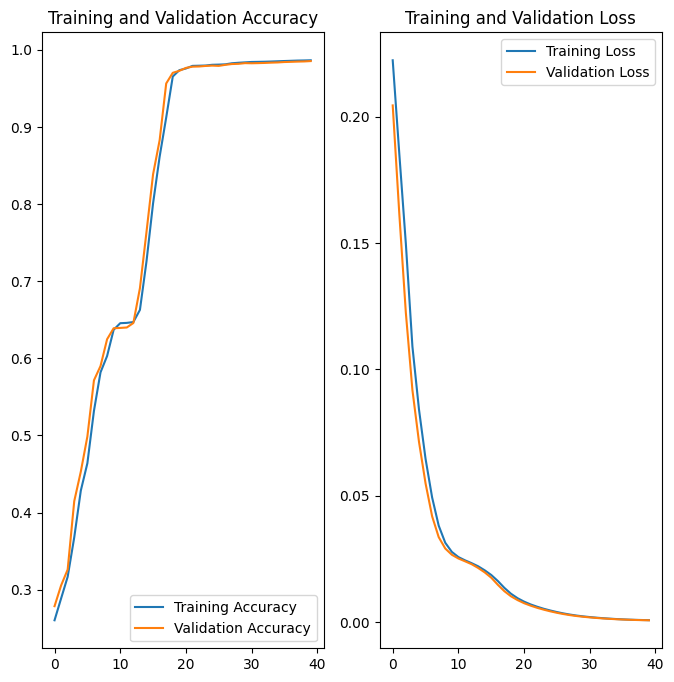

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
cnn_autoencoder_front.save('/gdrive/My Drive/Yedek/Models_Static_v3/Left45', options=save_locally)

In [12]:
with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    reconstructed_front = tf.keras.models.load_model('/gdrive/My Drive/Yedek/Models_Static_v3/Left45', options=load_locally)

In [13]:
xm_train=reconstructed_front.encoder(X_train)
xm_test=reconstructed_front.encoder(X_test)


In [14]:
xm_train.shape

TensorShape([205, 60, 80, 32])

In [15]:
xm_train.shape[0]

205

In [16]:
xm_train=tf.reshape(xm_train,[xm_train.shape[0],-1])
xm_test=tf.reshape(xm_test,[xm_test.shape[0],-1])

## **Machine Learning**

In [17]:
from sklearn.metrics import classification_report

In [18]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

xm_train=scaler.fit_transform(xm_train)
xm_test=scaler.transform(xm_test)

In [19]:
from sklearn.svm import SVC

svc=SVC(kernel="sigmoid")
svc.fit(xm_train, y_train)

SVC(kernel='sigmoid')

In [20]:
y_pred=svc.predict(xm_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[52  5]
 [ 7 23]]
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90        57
         1.0       0.82      0.77      0.79        30

    accuracy                           0.86        87
   macro avg       0.85      0.84      0.84        87
weighted avg       0.86      0.86      0.86        87



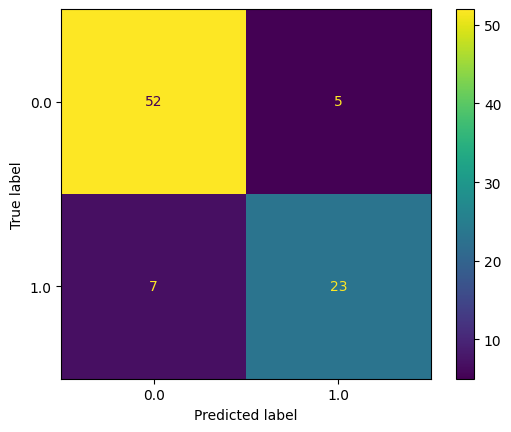

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()